In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv, json
import pandas as pd
import scipy.optimize as sp
import itertools

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/RSRG_class.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py

In [172]:
run_dir = "blkordered_bdrysweep/"

log_file = pd.read_csv(run_dir+"bdry_log_file.csv")
ts_list = log_file['ts'].tolist()
log_file[:22]

,L,steps,w_blk,w_bdry,w_mixed,n_runs,ts
0,60,3580,2.54,2.0,2.54,960,8375212253
1,60,3580,2.54,2.6,2.54,960,8375212259
2,60,3580,2.54,3.0,2.54,960,8375212263
3,60,3580,2.54,3.8,2.54,960,8375212229
4,60,3580,2.54,2.4,2.54,960,8375212286
5,60,3580,2.54,1.2,2.54,960,8375212282
6,60,3580,2.54,3.2,2.54,960,8375212261
7,60,3580,2.54,1.8,2.54,960,8375212268
8,60,3580,2.54,2.2,2.54,960,8375212264
9,60,3580,2.54,1.6,2.54,960,8375212229


In [173]:
ts = str(ts_list[0])

with open(run_dir+"IsingB_2D_input_"+ts+".pkl", "rb") as fp:   
    input_dict = pickle.load(fp)
        
with open(run_dir+"IsingB_2D_clusters_"+ts+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)
    
measure_list = input_dict['measure_list']
hblk_dist_list = [np.array([]) for step in range(len(measure_list))]
hbdry_dist_list = [np.array([]) for step in range(len(measure_list))] 

#In2029_hbd_m19

with open(run_dir+"IsingB_2D_output_"+ts+".txt", 'r') as reader:
    next(reader)
    for line in reader:
        #marker_end = line.find('[')
        inst_num = int(line[2:6])
        coupling_type = line[7:10]
        measure_ind = int(line[12:14])
        couplings = np.array(json.loads(line[14:]))
        if coupling_type == 'hbl':
            if len(hblk_dist_list[measure_ind]) == 0:
                hblk_dist_list[measure_ind] = couplings
            else:
                hblk_dist_list[measure_ind] = np.concatenate((hblk_dist_list[measure_ind], couplings))
        elif coupling_type == 'hbd':
            if len(hbdry_dist_list[measure_ind]) == 0:
                hbdry_dist_list[measure_ind] = couplings
            else:
                hbdry_dist_list[measure_ind] = np.concatenate((hbdry_dist_list[measure_ind], couplings))
                


#print(input_dict)

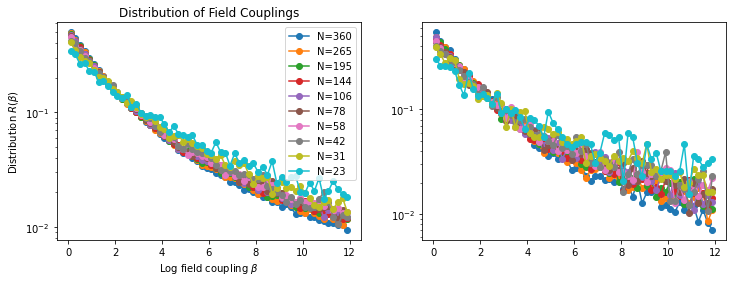

In [174]:
measure_list = input_dict['measure_list']
L = input_dict['L']
spins_left = L*L - measure_list
n_runs = input_dict['n_runs']
n_bins_h = 60
width_blk_list = []
width_bdry_list = []
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for i,step in enumerate(spins_left[:-1]): 
    n_blk,bins_blk = np.histogram(hblk_dist_list[i], density=True, bins = n_bins_h, range=(0,12))
    width_blk = bins_blk[1]-bins_blk[0]
    x_blk = (bins_blk[1:]-width_blk/2)
    y_blk = n_blk 

    popt, pcov = curve_fit(exponential_dist_norm, x_blk[:15], y_blk[:15])
    #plt.plot(x, exponential_dist_norm(x, *popt))
    width_blk_list.append(1/popt[0])
    
    n_bdry,bins_bdry = np.histogram(hbdry_dist_list[i], density=True, bins = n_bins_h, range=(0,12))
    width_bdry = bins_bdry[1]-bins_bdry[0]
    x_bdry = (bins_bdry[1:]-width_bdry/2)
    y_bdry = n_bdry
    if i%2==0:
        axes[0].plot(x_blk, y_blk, label="N="+str(step), marker='o')
        axes[1].plot(x_bdry, y_bdry, label="N="+str(step), marker='o')

    popt, pcov = curve_fit(exponential_dist_norm, x_bdry[:15], y_bdry[:15])
    #plt.plot(x, exponential_dist_norm(x, *popt))
    width_bdry_list.append(1/popt[0])

axes[0].set_yscale('log')
axes[1].set_yscale('log')
#plt.xlim(0, 6)
#plt.ylim(1e-1, 1)

axes[0].set_xlabel(r"Log field coupling $\beta$")
axes[0].set_ylabel(r"Distribution $R(\beta)$")
axes[0].set_title("Distribution of Field Couplings")
#plt.yscale('log')
axes[0].legend()

[ 0.63725402 48.29492184]
[ 0.73423564 80.65103919]


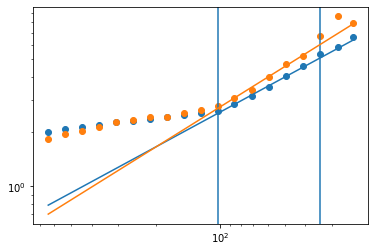

In [18]:
L = 80

x = (L*L - measure_list)[:-1]


plt.scatter(x, width_blk_list)


start = -9
end = -3

plt.axvline(x=x[start])
plt.axvline(x = x[end])
popt, pcov = curve_fit(power_law_scale, x[start:end], width_blk_list[start:end])
plt.plot(x, power_law_scale(x, *popt))
print(popt)
plt.scatter(x, width_bdry_list)

popt, pcov = curve_fit(power_law_scale, x[start:end], width_bdry_list[start:end])
plt.plot(x, power_law_scale(x, *popt))
print(popt)
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')


In [15]:
L*L - measure_list

array([640, 533, 444, 370, 308, 257, 214, 178, 148, 123, 103,  86,  71,
        59,  49,  41,  34,  28,  24,  20])

In [175]:
L = 80
fixed_length_slice = log_file[log_file['L']==L]
ts_list = fixed_length_slice['ts'].tolist()

w_vals = fixed_length_slice['w_bdry'].tolist()
largest_clust_size = []
var_lcs = [] 
c_list = []
c_dict = {50:'red', 70:'blue', 60:'green', 80:'cyan', 30:'orange', 100:'magenta', 85:'orange'}

for index, ts in enumerate(ts_list):

    with open(run_dir+"IsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)

    #print(input_dict)
    clust_dict_list, reverse_dict_list = [], []

    for core_pair in clust_list_final:
        clust_list_temp = core_pair[0] 
        reverse_list_temp = core_pair[1]
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp

    largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])
    
    largest_clust_size.append(largest_clust_list.mean()/L**2)
    var_lcs.append(largest_clust_list.std()/L**2)
    c_list.append(c_dict[L])

Text(0.5, 1.0, 'Largest Spin Cluster and Variance in Size')

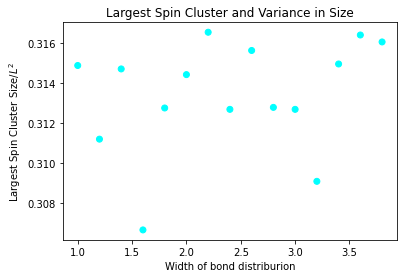

In [176]:
#plt.errorbar(w_vals, largest_clust_size, yerr=var_lcs, marker='o', linestyle='')
plt.scatter(w_vals, largest_clust_size, c=c_list)
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster and Variance in Size")

In [165]:
L_list = [60, 80]

w_vals_comp = []
lcs_comp = []
lcs_bdry_comp = []

for L in L_list:
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w_blk'].tolist()
    largest_clust_size = []
    largest_clust_size_bdry = []
    var_lcs = [] 
    c_list = []
    

    for index, ts in enumerate(ts_list):

        with open(run_dir+"IsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list, bdry_dict_list = [], [], []

        for core_pair in clust_list_final:
            clust_list_temp, reverse_list_temp,bdry_temp = core_pair
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp
            bdry_dict_list+=bdry_temp
            
        largest_clust_list_bdry = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None and bdry_dict_list[i][clust[0]]]) for i,reverse_dict in enumerate(reverse_dict_list)])
        
        largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])

        
        largest_clust_size.append(largest_clust_list.mean()/L**2)
        largest_clust_size_bdry.append(largest_clust_list_bdry.mean()/L**2)
        #var_lcs.append(largest_clust_list.std()/L**2)
        #c_list.append(c_dict[L])
    
    w_vals_comp.append(w_vals)
    lcs_comp.append(largest_clust_size)
    lcs_bdry_comp.append(largest_clust_size_bdry)
    

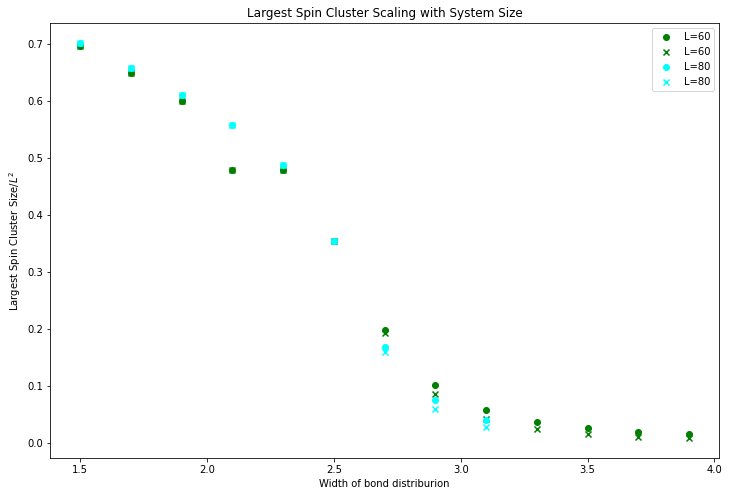

In [166]:
plt.figure(figsize=(12, 8))
for i, L in enumerate(L_list):
    plt.scatter(w_vals_comp[i], lcs_comp[i], c=c_dict[L], label='L='+str(L))
    plt.scatter(w_vals_comp[i], lcs_bdry_comp[i], c=c_dict[L], label='L='+str(L), marker='x')
    
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster Scaling with System Size")
plt.legend()

In [185]:
L_list = [60, 80]#, 70, 85, 50]
clust_size_list_comp = []
clust_size_list_bdry_comp = []
w_vals_comp = []
run_dir = "blkordered_bdrysweep/"
log_file = pd.read_csv(run_dir+"bdry_log_file.csv")

for L in L_list:
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w_bdry'].tolist()
    clust_size_list = []
    clust_dict_list_bdry = []
    

    for index, ts in enumerate(ts_list):

        with open(run_dir+"IsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list, bdry_dict_list = [], [], []

        for core_pair in clust_list_final:
            clust_list_temp, reverse_list_temp,bdry_list_temp = core_pair
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp
            bdry_dict_list+=bdry_list_temp
        
        clust_sizes = np.array(list(itertools.chain.from_iterable([[len(clust) for clust in rd.values() if clust is not None] for rd in reverse_dict_list])))
        #List of sizes of all clusters normalized to system size
        clust_sizes_bdry = np.array(list(itertools.chain.from_iterable([[len(clust) for clust in rd.values() if clust is not None and bdry_dict_list[i][clust[0]]] for i,rd in enumerate(reverse_dict_list)])))
       
        clust_size_list.append(clust_sizes[clust_sizes!=1]/L**2)
        clust_dict_list_bdry.append(clust_sizes_bdry[clust_sizes_bdry!=1]/L**2)
    w_vals_comp.append(w_vals)
    clust_size_list_comp.append(clust_size_list)
    clust_size_list_bdry_comp.append(clust_dict_list_bdry)

(2.0, 4.0)

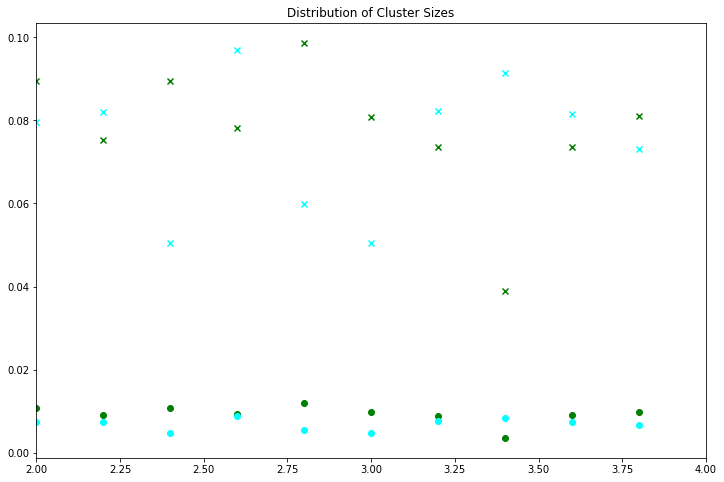

In [186]:
from scipy.ndimage import gaussian_filter1d
import scipy.signal as sg

fig, ax0 = plt.subplots(figsize=(12, 8))

c_dict = {50:'red', 70:'blue', 60:'green', 80:'cyan', 30:'orange', 100:'magenta', 85:'orange'}
cmap_type = {50:'Greens', 60:'Blues', 80:'Reds', 100:'Greys'}
for ind, L in enumerate(L_list):
    curve_check = []
    curve_check_bdry = []
    mean_clust_size = []
    cdf_max = []
    for index, w in enumerate(w_vals_comp[ind]):
        #if not index%3==0: continue
        #if not index==3: continue    
        cmap_L = cm.get_cmap(cmap_type[L])
        norm = plt.Normalize(2, 3)
        hist, bin_edges = np.histogram(clust_size_list_comp[ind][index], density=True, bins=40)
        width = bin_edges[1]-bin_edges[0]
        x = bin_edges[1:]-width/2
        #ax0.plot(bin_edges[1:]-width/2, hist,color=cmap_L(norm(w)), marker='o')
        
        cdf = np.cumsum(hist)
        #ax0.plot(x,cdf, color=cmap_L(norm(w)))
        smooth = gaussian_filter1d(cdf, 1)
        #ax0.plot(x, smooth, color=cmap_L(norm(w)), linestyle='--')
        second_der = np.gradient(np.gradient(smooth))
        #ax1 = ax0.twinx()
        #ax1.plot(x,second_der, color=cmap_L(norm(w)))
        a = np.diff(np.sign(np.diff(second_der))).nonzero()[0] + 1   
        #plt.scatter(x[a], second_der[a])
        infl_size = second_der[a[-2]]-second_der[a[-1]]
        curve_check.append(infl_size)
        #cdf_max.append(cdf[-1])
        #Attempt at doing statistics on cluster sizes
        """
        cs_list = clust_size_list_comp[ind][index]
        cs_list = cs_list[cs_list>(0.8*L/(L*L))]
        mean_clust_size.append(np.median(cs_list))
        """
        
        #Attempt at checking concavity of the distribution to identify transition
        """
        raw = np.log(hist)[5:]
        ax0.plot(raw, color=cmap_L(norm(w)))
        smooth = gaussian_filter1d(raw, 1)
        ax0.plot(smooth, color=cmap_L(norm(w)), linestyle='--')
        smooth_d1 = np.gradient(smooth[smooth>-4])
        curve_check.append(np.sum(smooth_d1))
        """
        
        hist, bin_edges = np.histogram(clust_size_list_bdry_comp[ind][index], density=True, bins=40)
        width = bin_edges[1]-bin_edges[0]
        x = bin_edges[1:]-width/2
        #ax0.plot(bin_edges[1:]-width/2, hist,color=cmap_L(norm(w)), marker='^', linestyle='--')
        cdf = np.cumsum(hist)
        smooth = gaussian_filter1d(cdf, 1)
        second_der = np.gradient(np.gradient(smooth))
        a = np.diff(np.sign(np.diff(second_der))).nonzero()[0] + 1
        infl_size = second_der[a[-2]]-second_der[a[-1]]
        curve_check_bdry.append(infl_size)
    
    #ax0.plot(w_vals_comp[ind], mean_clust_size, c=c_dict[L], marker='o')
    #ax0.scatter(w_vals_comp[ind], cdf_max, c=c_dict[L], marker='o')
    ax0.scatter(w_vals_comp[ind], curve_check, c=c_dict[L], marker='o')
    ax0.scatter(w_vals_comp[ind], curve_check_bdry, c=c_dict[L], marker='x')
    #fig, ax = plt.subplots(figsize=(6, 1))
    #fig.subplots_adjust(bottom=0.5)
    #cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap_L,
    #                            norm=norm,
    #                            orientation='horizontal')
    
ax0.set_title("Distribution of Cluster Sizes")
#ax0.xscale('log')
#ax0.set_yscale('log')
#plt.legend()
plt.xlim(2,4)

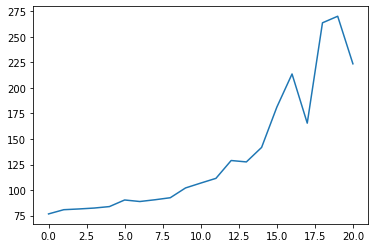

In [104]:
plt.plot(cdf_max)

In [177]:
def check_percolation(clust_dict, L):
    end_point = L-1
    for y1 in range(L):
        for y2 in range(L):
            start_ind = index_map(0, y1, L)
            end_index = index_map(end_point, y2, L)
            if (clust_dict[start_ind] == clust_dict[end_index]): 
                return True
    return False
        
def check_percolation_strip(clust_dict, L, width):
    end_point = L-1
    for y1 in range(L):
        for y1_width in range(0, width+1):
            for y2 in range(L):
                for y2_width in range(-width, 1):
                    start_ind = index_map(y1_width%L, y1, L)
                    end_index = index_map((end_point+y2_width)%L, y2, L)
                    if (clust_dict[start_ind] == clust_dict[end_index]): 
                        return True
    return False
        

Text(0.5, 1.0, 'Percolation Transition')

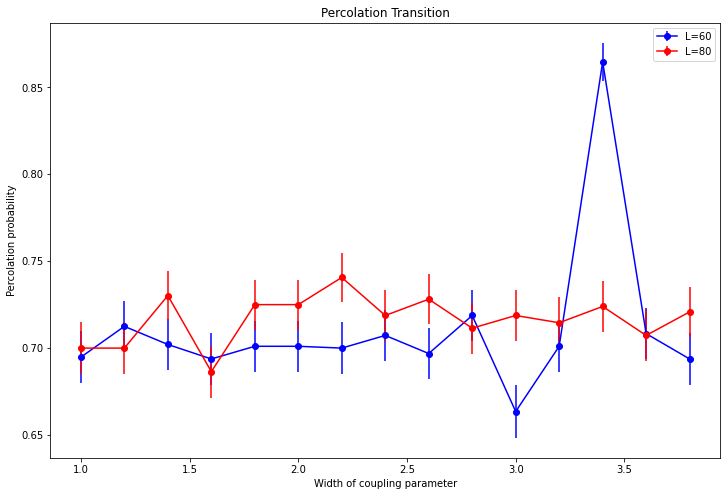

In [179]:
plt.figure(figsize=(12, 8))
c_dict = {60:'blue', 80:'red', 100:'green'}
for L in [60, 80]:
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w_bdry'].tolist()
    n_runs_list = fixed_length_slice['n_runs'].tolist()

    p_perc_clust = []
    p_perc_clust_err = []
    c_list = []
    

    for index, ts in enumerate(ts_list):

        with open(run_dir+"IsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []
        perc_cluster = []

        for core_pair in clust_list_final:
            clust_list_temp = core_pair[0]
            reverse_list_temp = core_pair[1]
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        perc_prob_temp = np.array([check_percolation_strip(clust, L, 0) for clust in clust_dict_list])

        p_perc_clust.append(perc_prob_temp.mean())
        p_perc_clust_err.append(perc_prob_temp.std()/np.sqrt(n_runs_list[index] - 1))
        c_list.append(c_dict[L])
   
    #plt.scatter(w_vals, p_perc_clust, c=c_list, label="L="+str(L))
    #plt.errorbar(w_vals, p_perc_clust, yerr=p_perc_clust_err, c=c_dict[L], label="L="+str(L))
    
    sorted_y = np.array([x for _,x in sorted(zip(w_vals,p_perc_clust))])
    sorted_y_err = np.array([x for _,x in sorted(zip(w_vals,p_perc_clust_err))])
    sorted_x = np.array(sorted(w_vals))
    plt.errorbar(sorted_x, sorted_y, c=c_dict[L], label="L="+str(L), marker='o', yerr=sorted_y_err)

    #x_lin = np.linspace(1.4, 3.8, 200)
    #plt.plot(x_lin, sigmoid_func(x_lin, *popt))
    

plt.legend()
plt.ylabel("Percolation probability")
plt.xlabel("Width of coupling parameter")
plt.title("Percolation Transition")

#Width=0, transition in between w=2.52 and w=2.56 region (run_set_1)

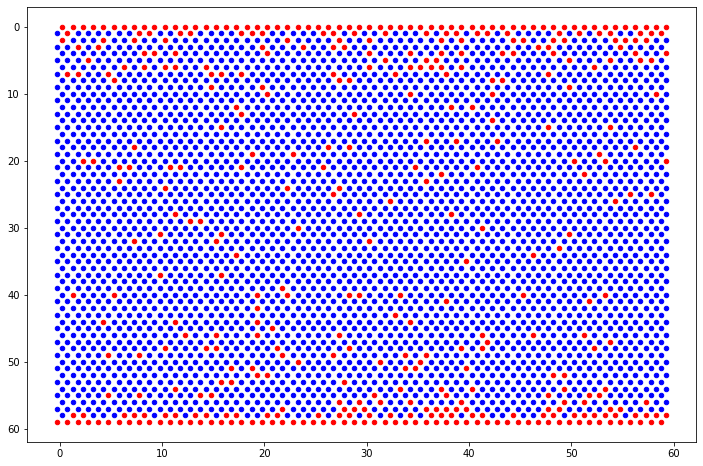

In [171]:
import matplotlib as mpl
import matplotlib.cm as cm

run_dir = "blksweep_bdryordered/"
log_file = pd.read_csv(run_dir+"bdry_log_file.csv")
L = 60
fixed_log_slice = log_file[lambda df: (df['L'] == L)]
ts_list = log_file['ts'].tolist()
ts = str(ts_list[0])


with open(run_dir+"IsingB_2D_clusters_"+ts+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)

plt.figure(figsize=(12, 8))
clust_dict = clust_list_final[1][0][0]
reverse_dict = clust_list_final[1][1][0]
bdry_dict = clust_list_final[1][2][0]

norm = mpl.colors.Normalize(vmin=0, vmax=4*L)
cmap = 'viridis'#cm.hsv
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for x in range(L):
    for y in range(L):
        
        site_ind = index_map(x, y, L)
        """
        if clust_dict[site_ind] == site_ind: c='blue'
        else: 
            c = m.cmap(len(reverse_dict[clust_dict[site_ind]]))
        """
        #c = m.cmap(len(reverse_dict[clust_dict[site_ind]]))
        if bdry_dict[site_ind]: c = 'red'
        else: c= 'blue'
        plt.scatter(y+(0.25*(-1)**(x%2)), x, color=c, s= 20)
        

plt.gca().invert_yaxis()

In [50]:
log_file

,L,steps,w_blk,w_bdry,w_mixed,n_runs,ts
0,60,3571,2.35,2.35,2.35,560,1682316020
1,60,3571,2.30,2.30,2.30,560,1682316079
2,60,3571,2.40,2.40,2.40,560,1682318942
3,60,3571,2.45,2.45,2.45,560,1682319002
4,60,3571,2.55,2.55,2.55,560,1682321999
5,60,3571,2.50,2.50,2.50,560,1682322023
6,60,3571,2.60,2.60,2.60,560,1682324940
7,60,3571,2.65,2.65,2.65,560,1682325106
8,60,3571,2.70,2.70,2.70,560,1682328013
9,60,3571,2.75,2.75,2.75,560,1682328237
